# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
from datetime import datetime
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings("ignore")

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [3]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [4]:
transcript.head(5)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [5]:
transcript.tail(5)

,person,event,value,time
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,{'amount': 4.05},714


In [6]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [7]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [8]:
#Check Null values in profile
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [9]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [10]:
#Remove age equals 118 (mean missing values)
profile = profile[profile['age'] != 118]

In [11]:
#change time to datetime format
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format = '%Y%m%d')

In [12]:
profile.isnull().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

In [13]:
transcript_event_dummies = pd.get_dummies(transcript['event'])

## Data Analysis

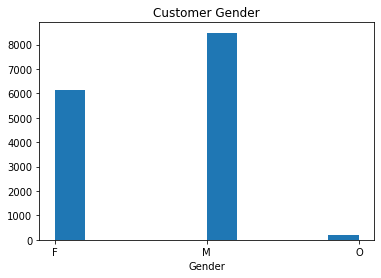

In [14]:
plt.hist(profile['gender'])
plt.xlabel('Gender')
plt.title('Customer Gender');

Male customer is more than female customer which are ~8000 and ~6000 respectively.

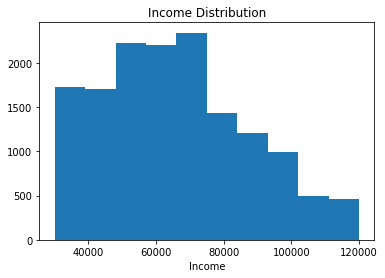

In [15]:
plt.hist(profile['income'])
plt.xlabel('Income');
plt.title('Income Distribution');

In [16]:
profile.income.median()

64000.0

In [17]:
profile.income.mean()

65404.9915682968

Most customers' income are around 60000. Median and mean income are 64000 and 65405 respectively.

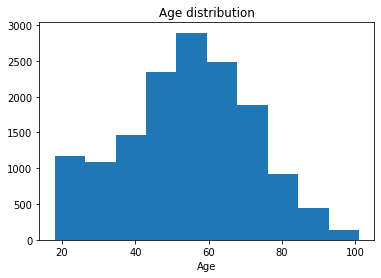

In [18]:
plt.hist(profile['age'])
plt.xlabel('Age')
plt.title('Age distribution');

We can see that age distribution is quite diversed. With most of the customer clustered around age 50-60.

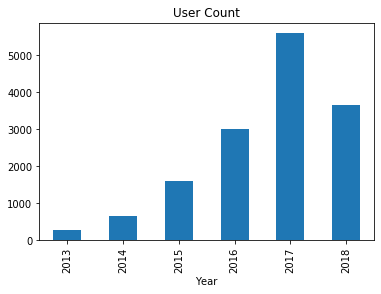

In [19]:
user_count = profile.groupby(profile['became_member_on'].dt.year).count()['id']
user_count.plot(kind = 'bar', color='C0')
plt.title('User Count')
plt.xlabel('Year');

User gradually increased from 2013 and reached the highest at 2017 and dropped in 2018.

## Transform data for training

In [20]:
transcript_expand_value = transcript.value.apply(pd.Series)

In [21]:
transcript_new = transcript.copy()

In [22]:
transcript_new = pd.concat([transcript_new,transcript_expand_value], axis=1).drop(['value'], axis=1)

In [23]:
transcript_new.drop_duplicates(inplace=True)

In [24]:
transcript_new.head()

,person,event,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [25]:
#get dummies for event type
transcript_new = pd.concat([transcript_new, pd.get_dummies(transcript_new['event'])], axis=1)

In [26]:
#join with the profile df
merged_df = pd.merge(profile, transcript_new ,left_on='id' , right_on='person',how='inner')

In [27]:
merged_df.drop(columns=['id'] , inplace=True)

In [28]:
#fill Nans reward and amount value with 0
merged_df.reward.fillna(0 , inplace=True)
merged_df.amount.fillna(0 , inplace=True)

In [29]:
#merge two offer id to one column
merged_df['merged_offer_id'] = merged_df['offer id']
merged_df.loc[merged_df['offer id'].isnull(), 'merged_offer_id'] = merged_df['offer_id']
merged_df.drop(['offer_id', 'offer id'], axis=1, inplace=True)

In [30]:
#join with portfolio
merged_df = merged_df.merge(portfolio , left_on='merged_offer_id' , right_on='id', how='left')

In [31]:
#aggregate data by customer and offer type
data = merged_df.groupby(['person' , 'offer_type']).agg(
    {
         'offer completed':sum,   
         'offer received': sum, 
         'offer viewed': sum,  
        'age':'last',
        'gender':'last',
        'became_member_on':'last',
        'income':'last'
    }
).reset_index()

In [32]:
#calculate the offer completion rate
data['offer_completion_rate'] = data['offer completed'] / data['offer received']

In [33]:
#pivot and transform the data to be ready for training
data = pd.concat([data, data[['offer_type', 'offer_completion_rate']].pivot(columns='offer_type', values='offer_completion_rate')], axis = 1)

In [34]:
#Get the dummies for gender
data = pd.concat([data, pd.get_dummies(data.gender)], axis=1)

In [35]:
data.fillna(0 , inplace=True)

In [36]:
data_new = data.copy()
#get the year and month for training
data_new['year'] = data_new.became_member_on.dt.year
data_new['month'] = data_new.became_member_on.dt.month

In [37]:
#if the chance of using the bogo or discount >= 0.7 then they are sensitive to the promotion
data_new['bogo_sensitivity'] = data['bogo'] >= 0.7
data_new['discount_sensitivity'] = data['discount'] >= 0.7

In [38]:
#just keep the columns we need for training
data_new = data_new[['age', 'income', 'bogo_sensitivity', 'discount_sensitivity', 'year', 'month', 'F', 'M', 'O']]

In [39]:
#split the dependent and independent variables
X = data_new.drop(columns=['bogo_sensitivity' ,'discount_sensitivity'])
y_bogo = data_new['bogo_sensitivity']
y_discount = data_new['discount_sensitivity']

In [40]:
#perform random split on the data
X_train, X_test, y_bogo_train, y_bogo_test = train_test_split(X, y_bogo, random_state=42)
X_train, X_test, y_discount_train, y_discount_test = train_test_split(X, y_discount, random_state=42)

In [41]:
#train using AdaBoostClassifier
bogo_ada_model = AdaBoostClassifier()
bogo_ada_model.fit(X_train, y_bogo_train)
discount_ada_model = AdaBoostClassifier()
discount_ada_model.fit(X_train, y_discount_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [42]:
print("accurary score discount using adaboost: {}".format(accuracy_score(y_discount_test,discount_ada_model.predict(X_test))))
print("accurary score bogo using adaboost: {}".format(accuracy_score(y_bogo_test,bogo_ada_model.predict(X_test))))

accurary score discount using adaboost: 0.7967387611821991
accurary score bogo using adaboost: 0.8329747480466538


In [43]:
#train using GuassianNB
bogo_nb_model = GaussianNB()
bogo_nb_model.fit(X_train, y_bogo_train)
discount_nb_model = GaussianNB()
discount_nb_model.fit(X_train, y_discount_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [44]:
print("accurary score discount using GaussianNB: {}".format(accuracy_score(y_discount_test,discount_nb_model.predict(X_test))))
print("accurary score bogo using GaussianNB: {}".format(accuracy_score(y_bogo_test,bogo_nb_model.predict(X_test))))

accurary score discount using GaussianNB: 0.7968519986411505
accurary score bogo using GaussianNB: 0.8329747480466538


In [45]:
parameters = {
    'var_smoothing': [0.0000001, 0.00000001, 0.000000001]
}

cv = GridSearchCV(GaussianNB(), param_grid=parameters)
cv.fit(X_train, y_discount_train)
print("accurary score discount using different params: {}".format(accuracy_score(cv.predict(X_test), y_discount_test)))
print("best param is: {}".format(cv.best_params_))
cv.fit(X_train, y_bogo_train)
print("accurary score bogo using different params: {}".format(accuracy_score(cv.predict(X_test), y_bogo_test)))
print("best param is: {}".format(cv.best_params_))

accurary score discount using different params: 0.7968519986411505
best param is: {'var_smoothing': 1e-07}
accurary score bogo using different params: 0.8329747480466538
best param is: {'var_smoothing': 1e-07}


## Discussion

From the above exploration, we know that male customer is more than female customer which are ~8000 and ~6000 respectively. And most customers' income are around 60000. Median and mean income are 64000 and 65405 respectively. Moreover, we can see that age distribution is quite diversed. With most of the customer clustered around age 50-60. User gradually increased from 2013 and reached the highest at 2017 and dropped in 2018.

Therefore, a model to assist for promotion maybe useful to help retain the customer. The model deployed here are AdaboostClassifier and GaussianNB. We use gender, income, age and year/month that customer become member to see if they are sensitive to bogo/discount promotion. If the ratio of used offer and received offer is equal to or larger than 0.7. We will see them as sensitive to promotion.

If we use the model to predict using the personal information. We will get whether they are sensitive or not to the promotion and choose whether to send out the promotion to them or not. We can also adjust the promotion base on this. If they are not sensitive to promotion. We can send out a more attractive promotion to them e.g. bigger discount in order to retain the customer.

From the result, we can see that GaussianNB is performing better than AdaboostClassifier with the accuracy score 0.797 and 0.833 for bogo and discount promotion respectively. We can also see that identical result (accuracy score) with different parameters. For better performance, other model could be deployed to figure out if there is a better model to boost the accuracy score.